##### Daily weather analysis
Performing cluster analysis on the minute-weather.csv from:
https://eagronin.github.io/weather-clustering-spark-acquire/

In [2]:
import sklearn
import pandas as pd

In [6]:
df = pd.read_csv('minute_weather.csv')

In [4]:
df.count()

rowID                 1587257
hpwren_timestamp      1587257
air_pressure          1587257
air_temp              1587257
avg_wind_direction    1586824
avg_wind_speed        1586824
max_wind_direction    1586824
max_wind_speed        1586824
min_wind_direction    1586824
min_wind_speed        1586824
rain_accumulation     1587256
rain_duration         1587256
relative_humidity     1587257
dtype: int64

In [68]:
#filtering some of the data
filteredDF = df.loc[(df['rowID'] % 10) == 0]

In [8]:
filteredDF.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [10]:
workingDF = filteredDF.drop('rain_accumulation', 1).drop('rain_duration', 1).drop('hpwren_timestamp', 1)

In [11]:
before = workingDF.count()
workingDF = workingDF.dropna()
after = workingDF.count()
before - after

rowID                 46
air_pressure          46
air_temp              46
avg_wind_direction     0
avg_wind_speed         0
max_wind_direction     0
max_wind_speed         0
min_wind_direction     0
min_wind_speed         0
relative_humidity     46
dtype: int64

In [27]:
workingDF.columns

Index(['rowID', 'air_pressure', 'air_temp', 'avg_wind_direction',
       'avg_wind_speed', 'max_wind_direction', 'max_wind_speed',
       'min_wind_direction', 'min_wind_speed', 'relative_humidity'],
      dtype='object')

In [13]:
from sklearn import preprocessing
no_rowID = workingDF.drop('rowID', 1).drop('min_wind_speed', 1).drop('min_wind_direction', 1)

In [14]:
# scaling the data
scaler = preprocessing.StandardScaler().fit(no_rowID)
scaledData = pd.DataFrame(scaler.transform(no_rowID))
scaledData.columns = ['air_pressure', 'air_temp', 'avg_wind_direction','avg_wind_speed', 'max_wind_direction', 'max_wind_speed','relative_humidity']

The k-means algorithm requires that the value of k, the number of clusters, to be specified.  To determine a good value for k, we will use the elbow method.  This method involves applying k-means, using different values for k, and calculating the within-cluster sum-of-squared error (WSSE).  To speed up the process, we will use only a subset of the dataset, taking every third sample from the dataset to create this subset.

In [18]:
scaledData['rowID'] = workingDF['rowID'].to_numpy()
elbowset = pd.DataFrame(scaledData.loc[scaledData['rowID'] % 3 == 0], columns=scaledData.columns).drop('rowID', 1)
elbowset

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,-1.484563,0.245445,-0.683853,-0.765553,-0.621536,-0.744403,0.492338
3,-1.517332,0.062896,-0.746827,-0.376754,-0.653985,-0.413660,0.393131
6,-1.582869,0.184595,-0.830792,-1.008552,-0.675618,-1.033804,0.145113
9,-1.615638,-0.043590,-0.998722,0.400845,-0.956846,0.330513,0.950218
12,-1.648407,0.169383,-0.988226,-0.328154,-0.946029,-0.413660,0.606808
...,...,...,...,...,...,...,...
158666,-0.370422,1.097337,-1.439537,-0.668353,-1.389503,-0.744403,-0.041855
158669,-0.337653,1.127762,-1.460529,-0.814153,-1.432769,-0.827089,-0.072380
158672,-0.337653,1.173399,1.719642,-0.765553,1.877062,-0.744403,0.026827
158675,-0.304884,1.158187,1.761625,-0.862753,1.920328,-0.868432,0.007749


Computing the k-means clusters for k=2...30 to create an elbow plot:

In [16]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

n_clusters = range(2,31)

res = list()
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(elbowset)
    res.append(kmeans.inertia_)

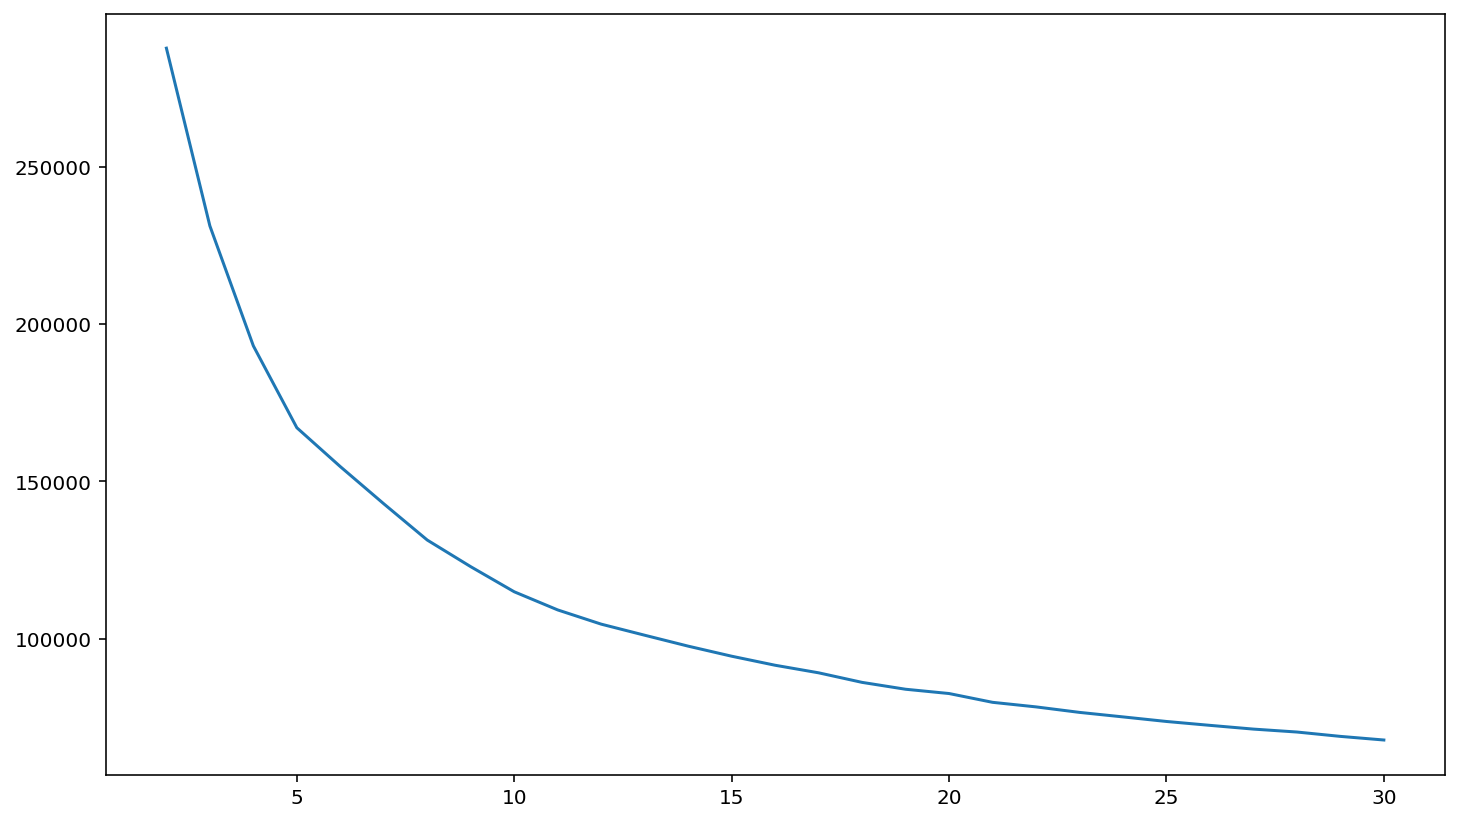

In [17]:
import matplotlib.pyplot as plt
plt.plot(n_clusters, res)

The values for k are plotted against the WSSE values, and the elbow, or bend in the curve, provides a good estimate for the value for k.  In this plot, we see that the elbow in the curve is between 10 and 15, so let's choose k=12.  We will use this value to set the number of clusters for k-means.

In [24]:
elbowset

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,-1.484563,0.245445,-0.683853,-0.765553,-0.621536,-0.744403,0.492338
3,-1.517332,0.062896,-0.746827,-0.376754,-0.653985,-0.413660,0.393131
6,-1.582869,0.184595,-0.830792,-1.008552,-0.675618,-1.033804,0.145113
9,-1.615638,-0.043590,-0.998722,0.400845,-0.956846,0.330513,0.950218
12,-1.648407,0.169383,-0.988226,-0.328154,-0.946029,-0.413660,0.606808
...,...,...,...,...,...,...,...
158666,-0.370422,1.097337,-1.439537,-0.668353,-1.389503,-0.744403,-0.041855
158669,-0.337653,1.127762,-1.460529,-0.814153,-1.432769,-0.827089,-0.072380
158672,-0.337653,1.173399,1.719642,-0.765553,1.877062,-0.744403,0.026827
158675,-0.304884,1.158187,1.761625,-0.862753,1.920328,-0.868432,0.007749


In [47]:
new_kmeans = KMeans(n_clusters=12)
model = new_kmeans.fit(elbowset)
transformed = model.transform(elbowset)

centers = new_kmeans.cluster_centers_

In [48]:
import numpy as np
centersDF = pd.DataFrame(centers, columns = elbowset.columns)
centersDF['cluster'] = np.arange(centersDF.shape[0])
centersDF

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,cluster
0,0.797506,0.338232,0.301771,-0.528511,0.491841,-0.534313,-0.765547,0
1,-0.845658,-1.192024,0.376973,0.428037,0.473406,0.412356,1.352835,1
2,-0.655189,0.573594,0.178486,-0.588486,0.348201,-0.602760,-0.143207,2
3,1.353953,-0.075227,-1.213914,-0.078200,-1.081752,-0.060598,-0.962557,3
4,0.196758,-1.008350,0.650240,-0.538211,0.839152,-0.520494,1.182838,4
5,-0.167629,0.870660,-1.306622,-0.587678,-1.159956,-0.601544,-0.643692,5
6,-1.195479,-0.855187,0.443132,2.002481,0.535501,1.964027,0.892633,6
7,-0.210380,0.637983,0.410133,0.734316,0.517264,0.670077,-0.153459,7
8,0.245225,0.308248,1.885233,-0.648454,-1.552928,-0.573439,-0.280650,8
9,0.107897,0.876111,1.401284,-0.642153,1.664953,-0.593973,-0.709000,9


##### Dry days

(-3.0, 3.0)

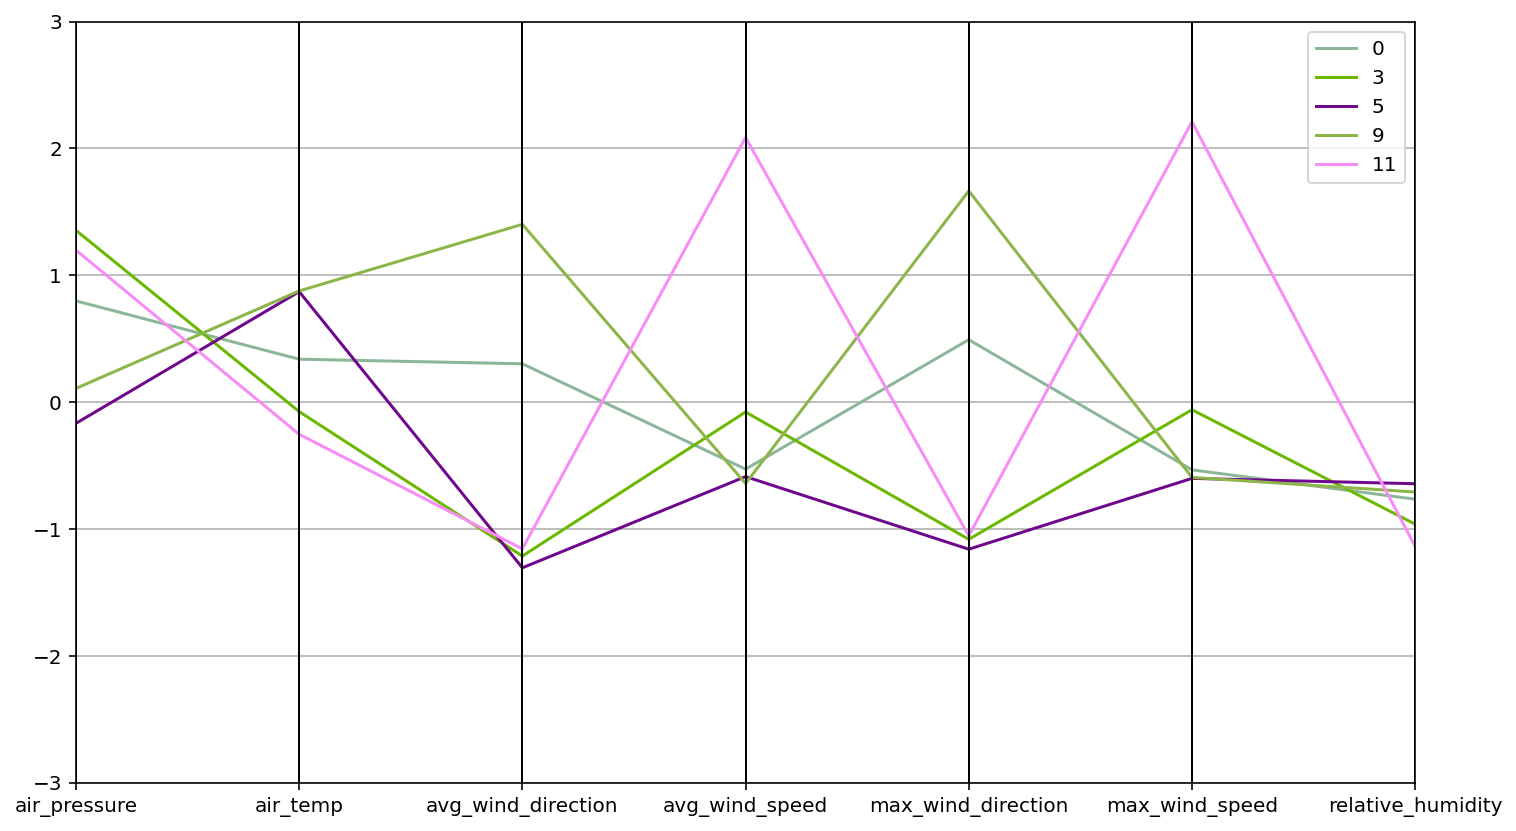

In [62]:
#dry days
pd.plotting.parallel_coordinates(centersDF[centersDF['relative_humidity'] < -0.5], 'cluster').set_ylim([-3, 3])

##### Warm days

(-3.0, 3.0)

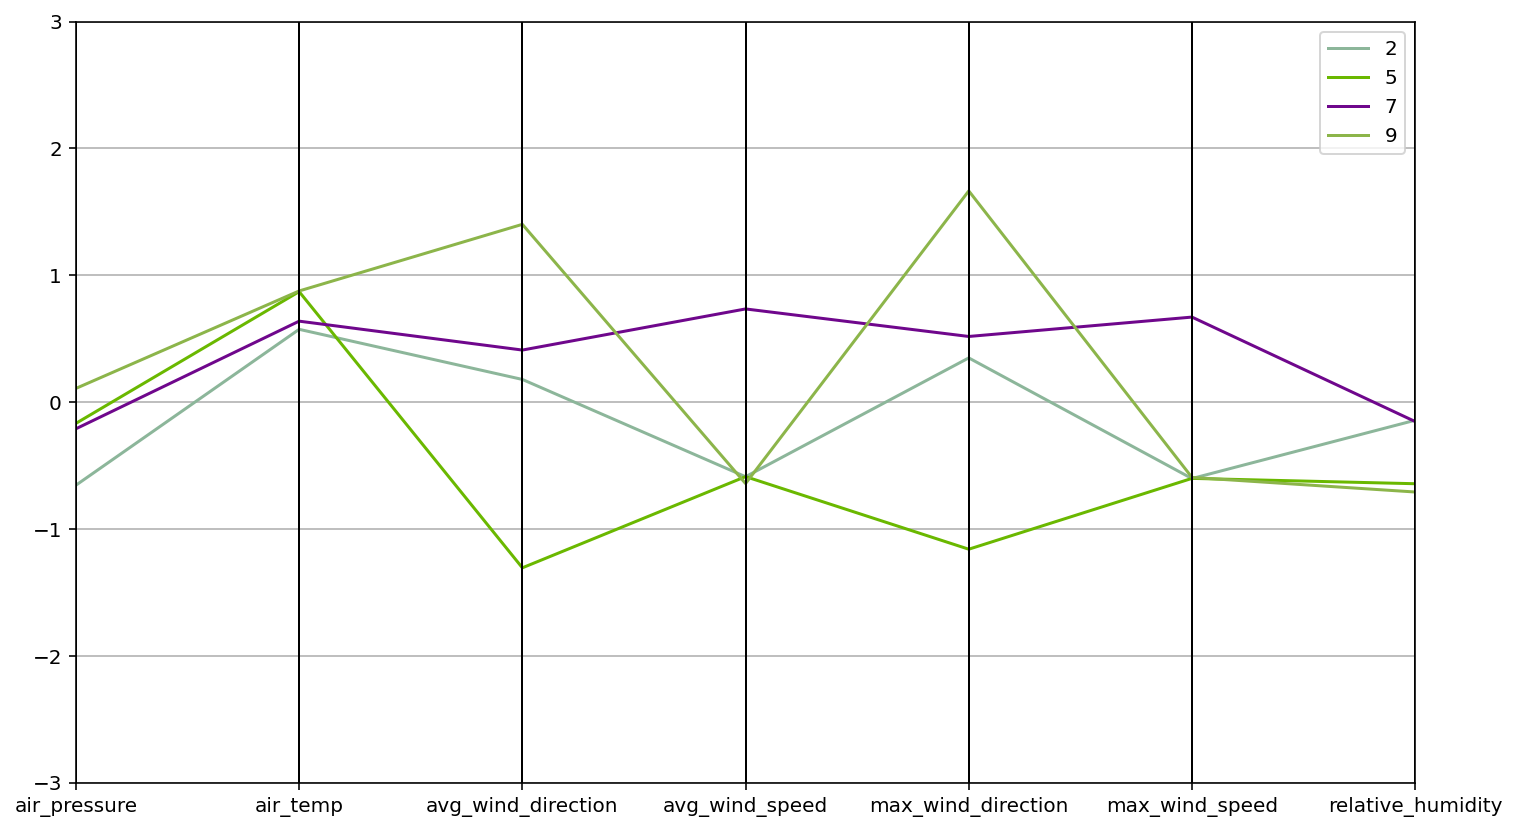

In [63]:
#warm days
pd.plotting.parallel_coordinates(centersDF[centersDF['air_temp'] > 0.5], 'cluster').set_ylim([-3, 3])

##### Cool days

(-3.0, 3.0)

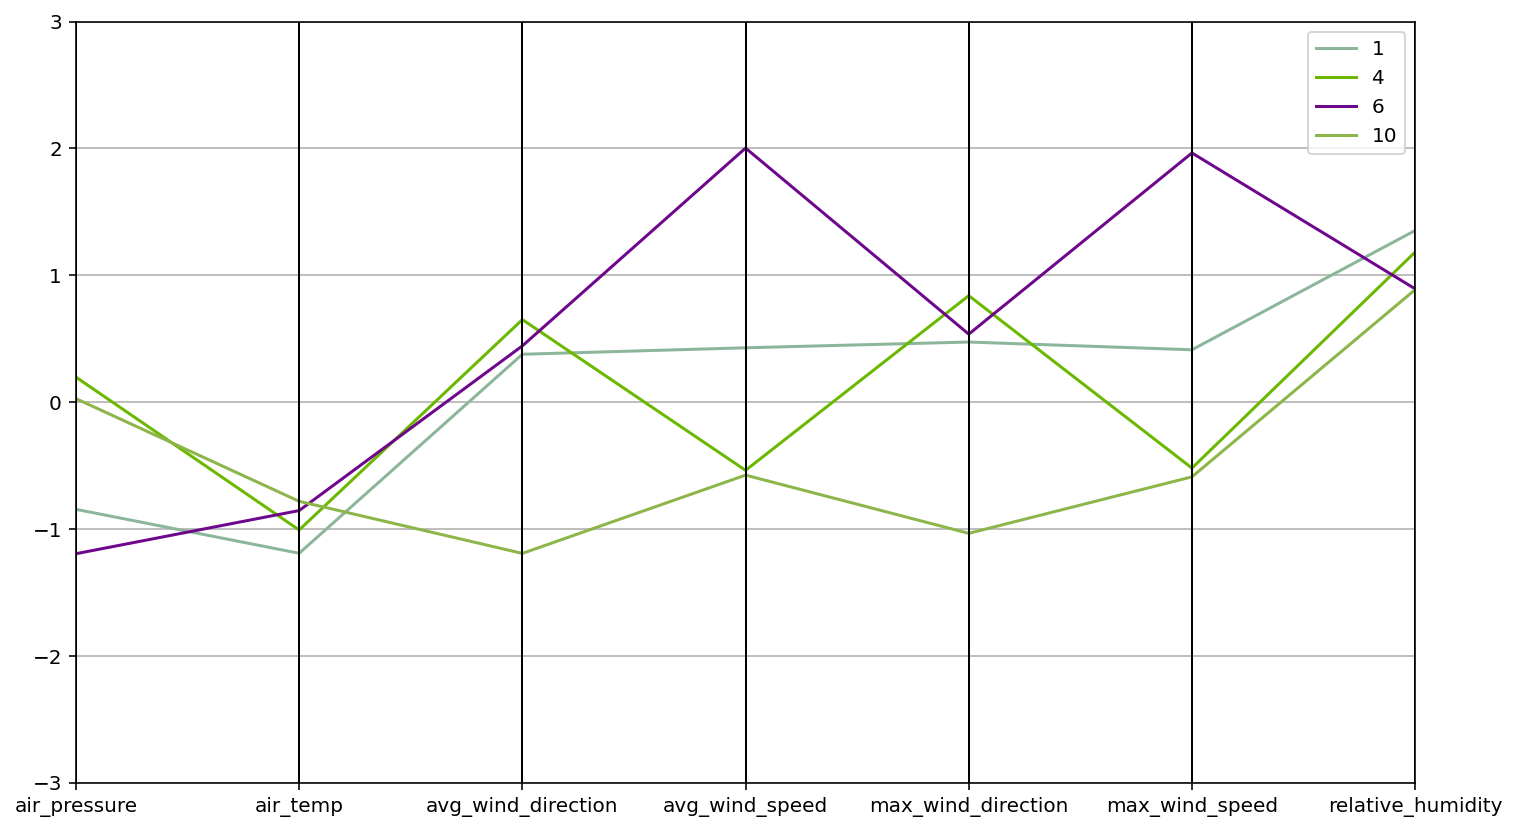

In [64]:
#cool days
pd.plotting.parallel_coordinates(centersDF[(centersDF['relative_humidity'] > 0.5) & (centersDF['air_temp'] < 0.5)], 'cluster').set_ylim([-3, 3])

So far, we've seen all the clusters except 8 since it did not fall into any of the other categories. Let's plot this cluster:

(-3.0, 3.0)

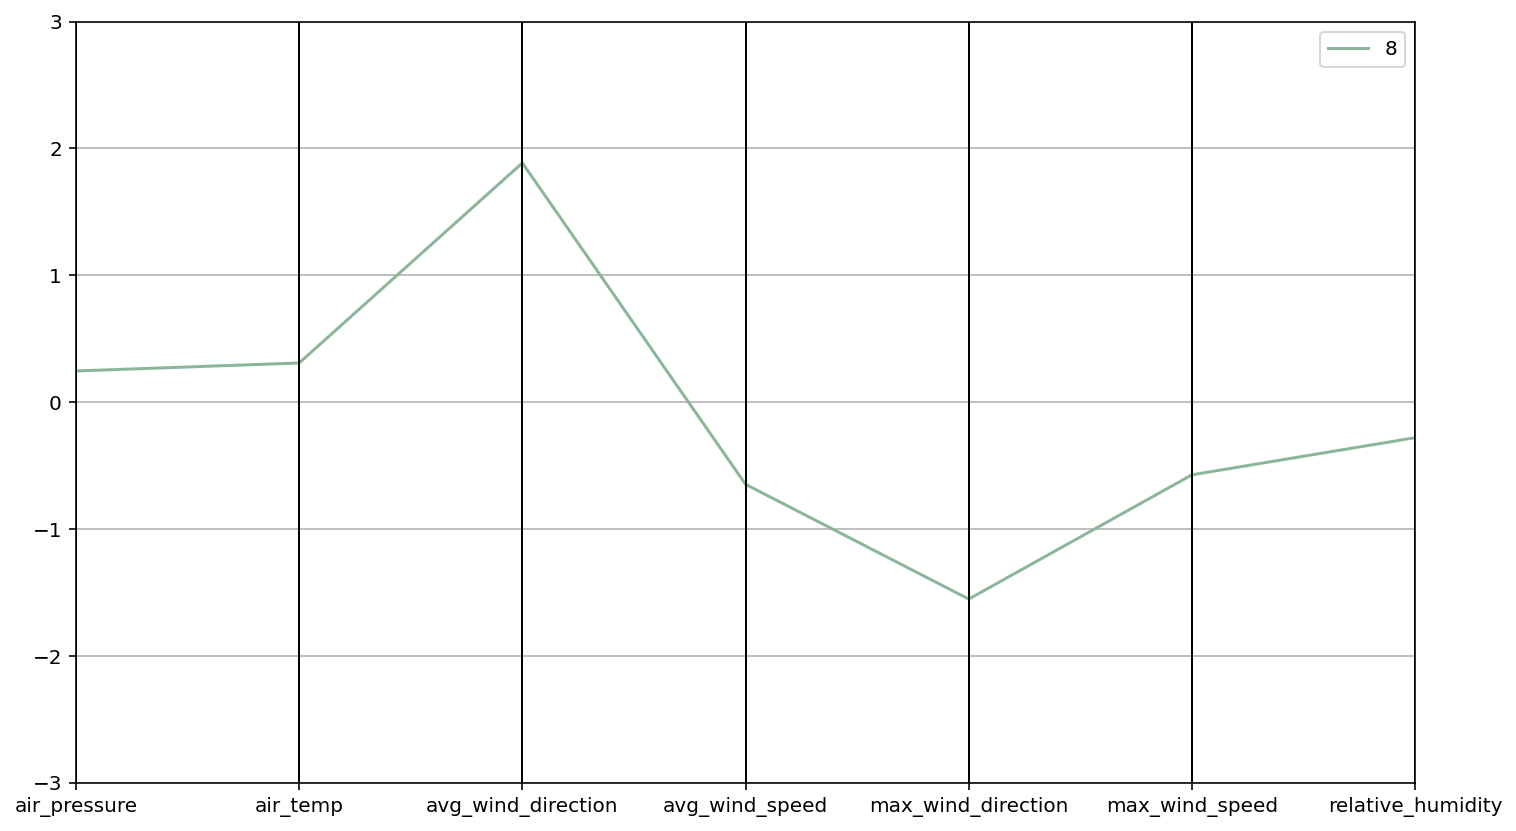

In [66]:
pd.plotting.parallel_coordinates(centersDF[centersDF['cluster'] == 8], 'cluster').set_ylim([-3, 3])

Cluster 8 captures milder weather with high winds.